# 0.0 Tools

## 0.1. Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# import psycopg2 as pg
import scikitplot as skplt
import matplotlib.pyplot as plt
import os
import pickle
import inflection

from scipy                 import stats
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML

## 0.2. Load dataset

In [2]:
data = pd.read_csv('Data/train.csv')

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3. Helper Functions

In [206]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict 

# 1.0. Data Description

At this stage we will understand how the data is and how big the problem we are facing is.

In [4]:
df1 = data.copy()

## 1.1. Rename Columns

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
# data dimenstions
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3. Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Columns Description

* **id**	Unique ID for the customer
* **Gender**	Gender of the customer
* **Age**	Age of the customer
* **Driving_License**	0 : Customer does not have DL, 1 : Customer already has DL
* **Region_Code**	Unique code for the region of the customer
* **Previously_Insured**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* **Vehicle_Age**	Age of the Vehicle
* **Vehicle_Damage**	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* **Annual_Premium**	The amount customer needs to pay as premium in the year
* **Policy_Sales_Channel**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage**	Number of Days, Customer has been associated with the company
* **Response**	1 : Customer is interested, 0 : Customer is not interested

## 1.6. Descriptive Statistical

In [9]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage',
                     'policy_sales_channel']]
target_attributes = df1['response']

### 1.6.1. Numerical Attributes

In [10]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


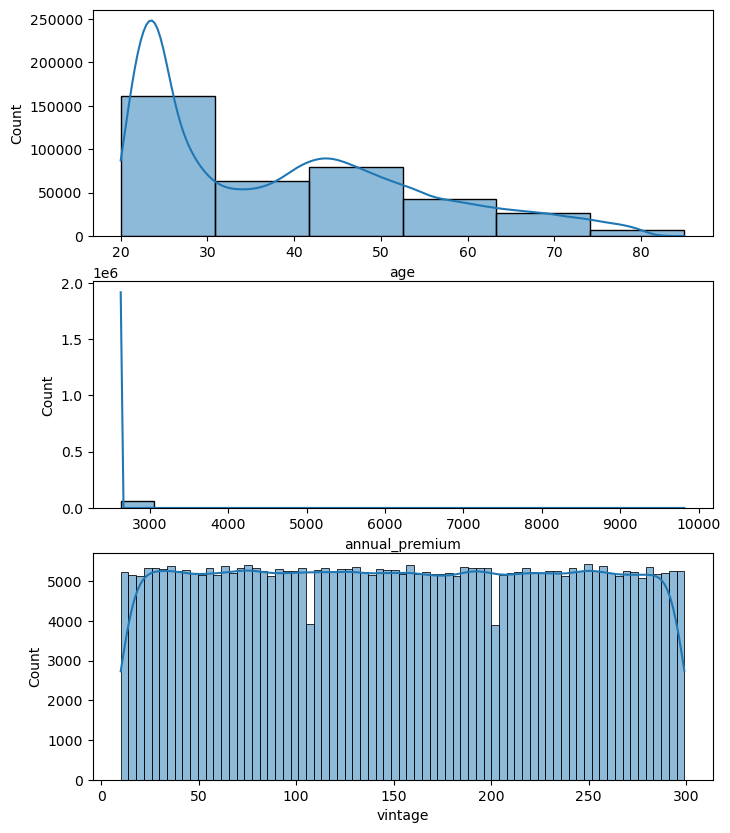

In [11]:
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.histplot(df1['age'], ax=axs[0], bins = 6, kde=True)
sns.histplot(df1[df1['annual_premium']<10000]['annual_premium'], ax=axs[1], kde=True)
sns.histplot(df1['vintage'], ax=axs[2], kde=True);

### 1.6.2. Categorical Attributes

In [12]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

<Axes: xlabel='gender', ylabel='count'>

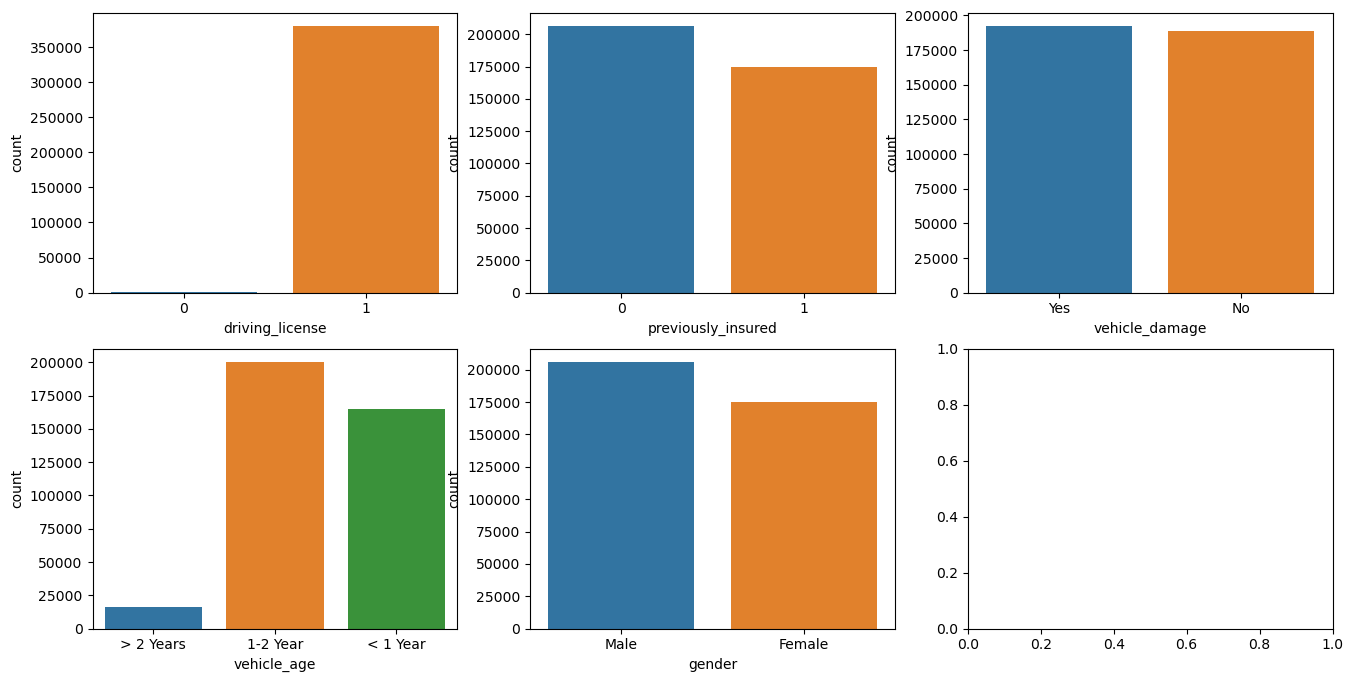

In [13]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16, 8))

sns.countplot(x = 'driving_license', data = df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data = df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data = df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', data = df1, ax=axs[1][0])
sns.countplot(x = 'gender', data = df1, ax=axs[1][1])

<Axes: xlabel='region_code', ylabel='count'>

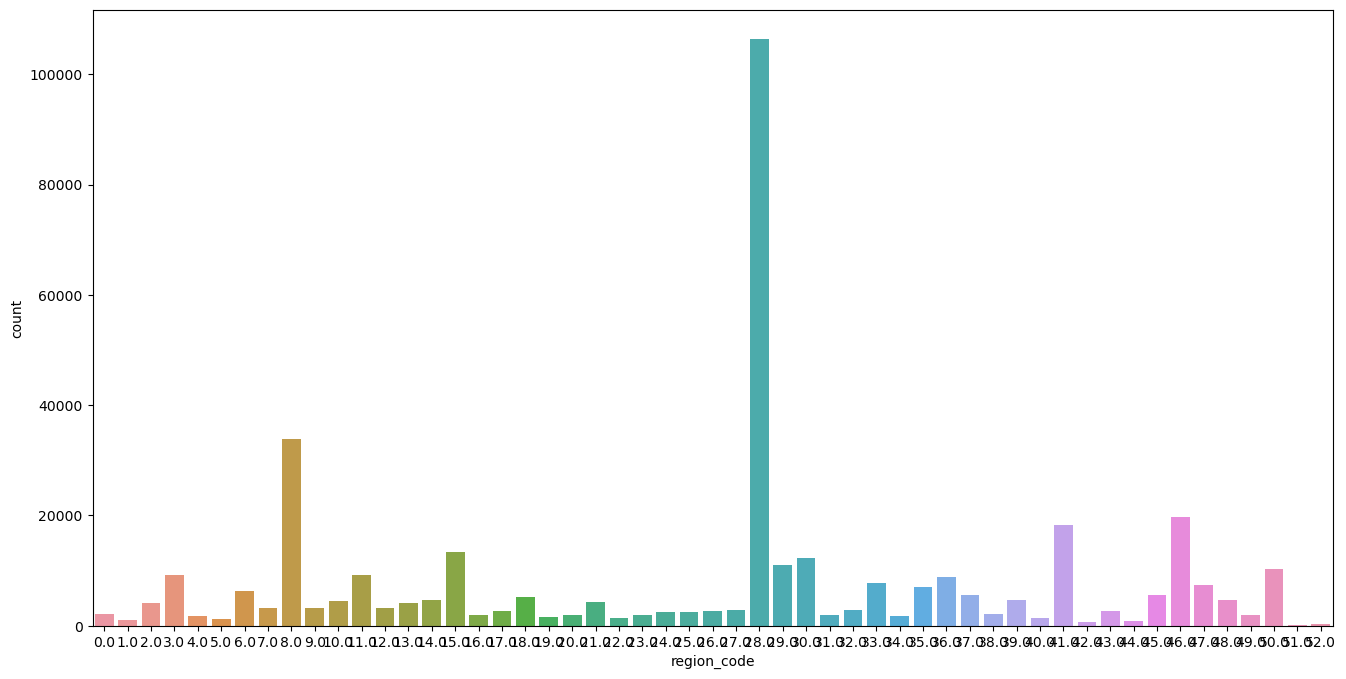

In [14]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'region_code', data = df1)

<Axes: xlabel='policy_sales_channel', ylabel='count'>

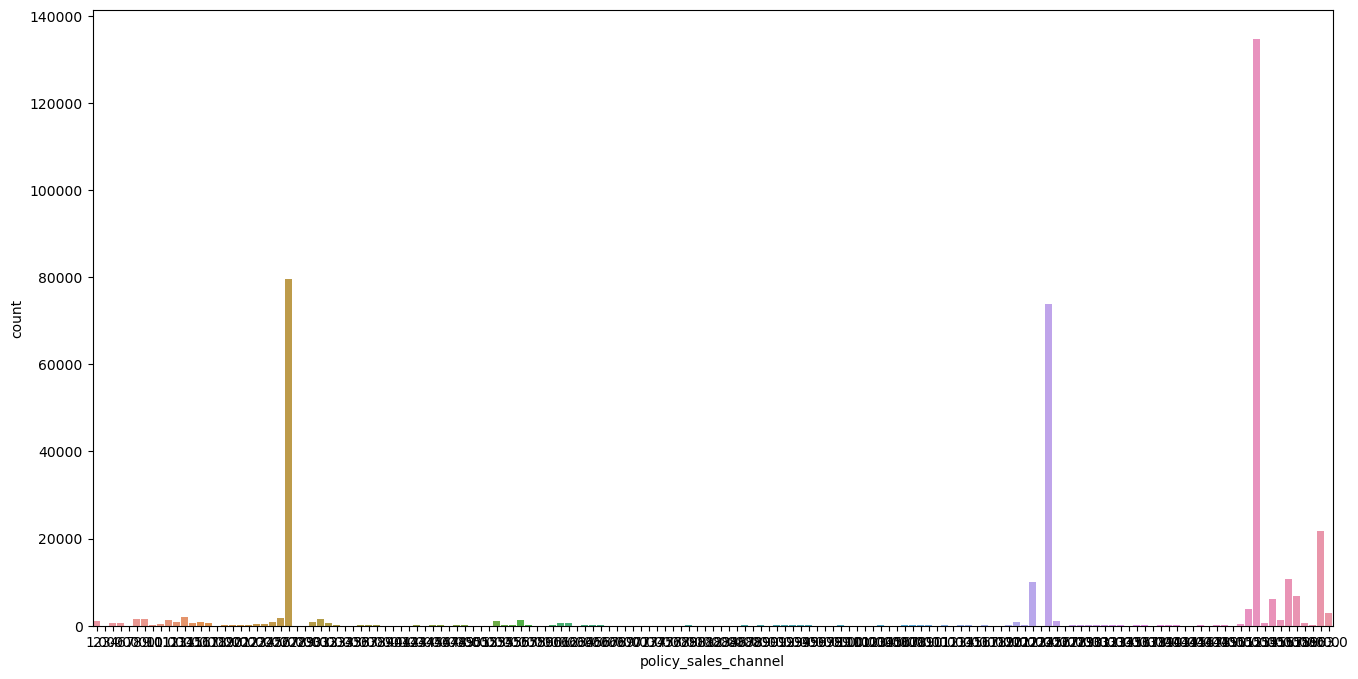

In [15]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'policy_sales_channel', data = df1)

In [16]:
# Olhando pros 4 maiores valores:
df1['policy_sales_channel'].value_counts().head(4)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
Name: policy_sales_channel, dtype: int64

### 1.6.3 Target Atribute

<Axes: xlabel='response', ylabel='count'>

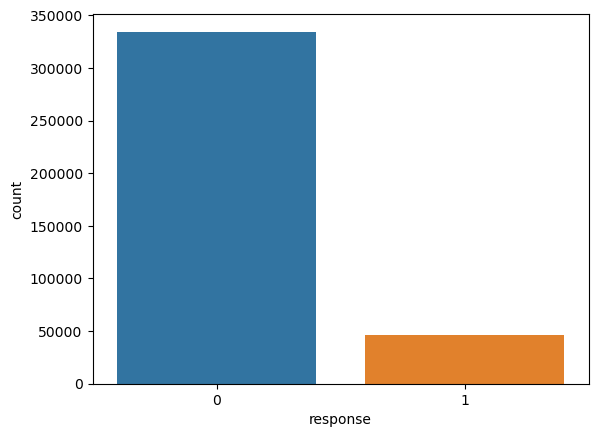

In [17]:
sns.countplot(x = 'response', data = df1)

# 2.0. Feature Engineering

In this step we will create features from existing variables.


## 2.1. Making Hypotesis

**1.** Male customers have more damaged vehicles

**2.** Male customers are more interested in buy vehicle insurance

**3.** Customers that pay less annual premium are more interested in buy vehicle insurance

**4.** Long time period customers are more insterested in buy vehicle insurance

**5.** Customers older than 36 are more interested in buy vehicle insurance

**6.** Customers with damaged vehicles are more interested in buy vehicle insurance

**7.** Customars with newer vehicles are more interested in buy vehicle insurance

**8.** Customers without driver license have no interest in buy vehicle insurance

**9.** Customers region code have no influence in the interest they have in buying vehicle insurance

**10**. Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance

## 2.2. Feature Engineering


In [18]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

At this stage, for now, we will not do any filtering on the data.

In [80]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis

At this stage the objective is:

* Understand the business and generate insights.
* Find relevant variables for model learning.

In [81]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

C:\Users\leona\AppData\Local\Temp\ipykernel_9556\3131037003.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


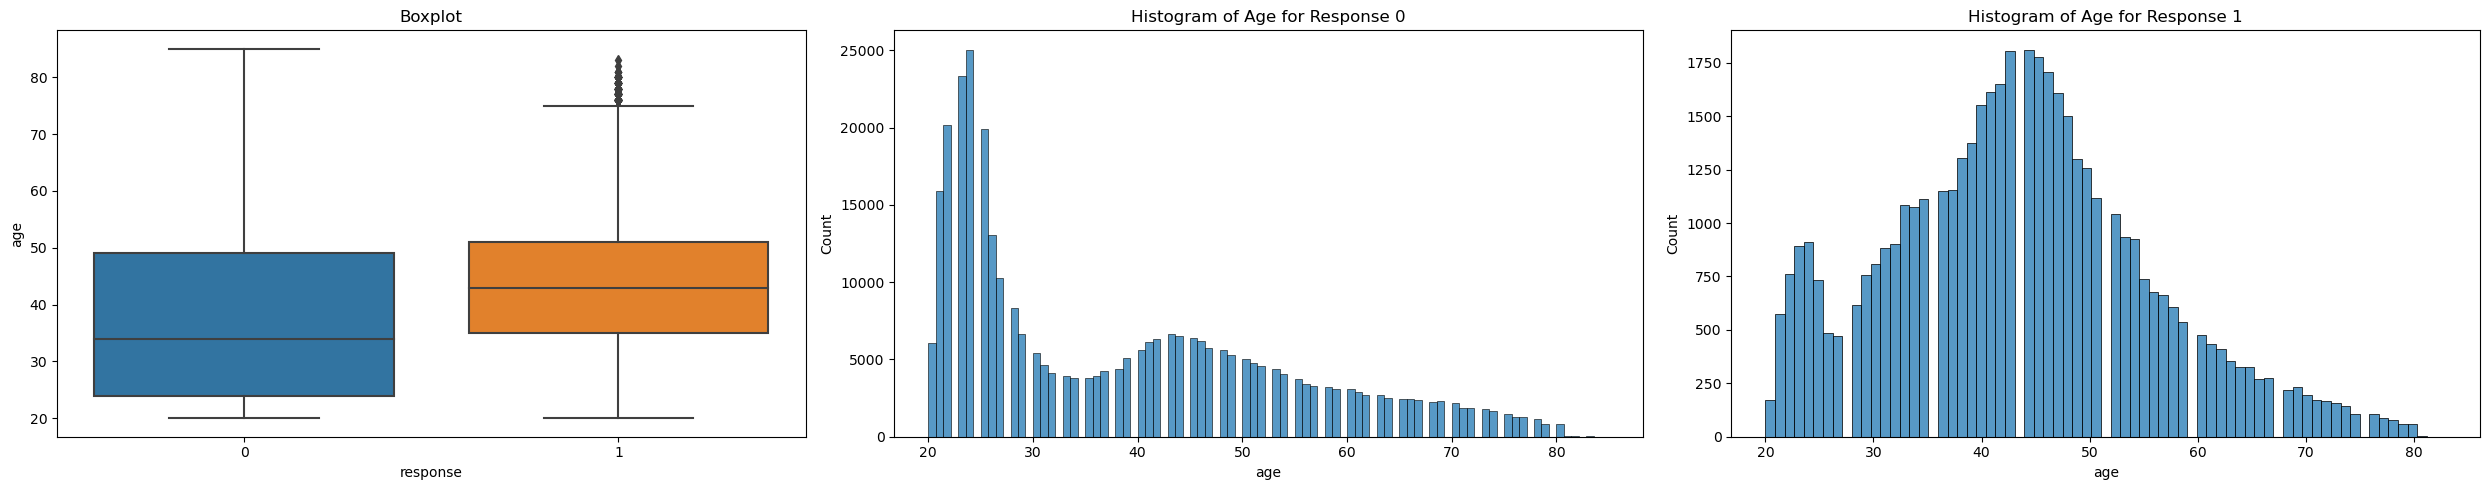

In [82]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='age', data=df4 )
plt.title('Boxplot')


# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(df4.loc[df4['response'] == 0, 'age'])
plt.title('Histogram of Age for Response 0')

# Subplot 2
plt.subplot(1, 3, 3)
sns.histplot(df4.loc[df4['response'] == 1, 'age'])
plt.title('Histogram of Age for Response 1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

### 4.1.2. Anual Income

C:\Users\leona\AppData\Local\Temp\ipykernel_9556\2250126909.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


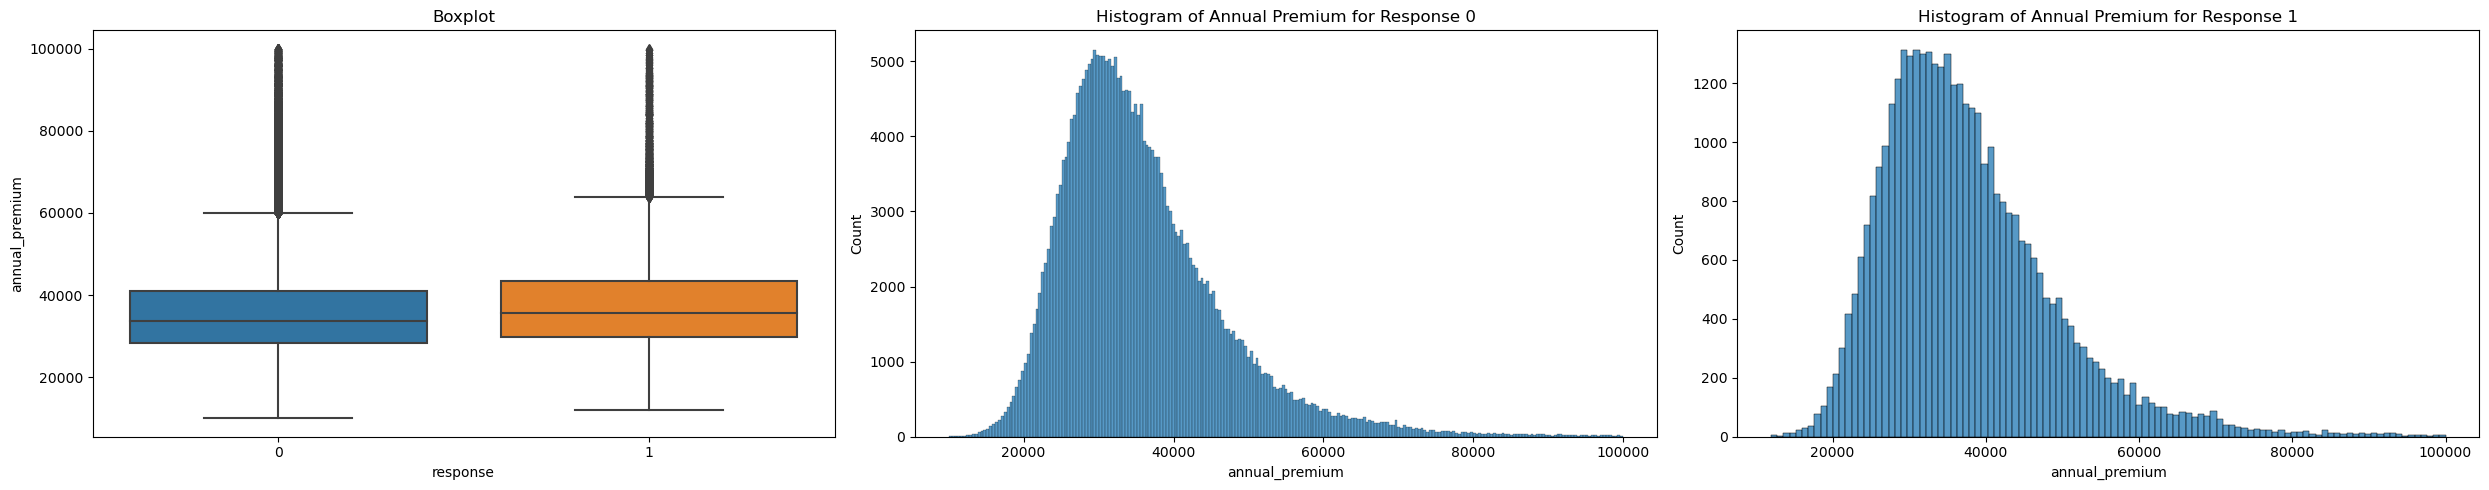

In [83]:
df4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]


fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='annual_premium', data=df4 )
plt.title('Boxplot')


# Subplot 2
plt.subplot(1, 3, 2)
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux00)
plt.title('Histogram of Annual Premium for Response 0')

# Subplot 2
plt.subplot(1, 3, 3)
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux00)
plt.title('Histogram of Annual Premium for Response 1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

The distribution is very similar, so with this variable we cannot differentiate much between the two groups (people who are interested and people who are not interested). So it seems that this variable will not help us much.

### 4.1.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

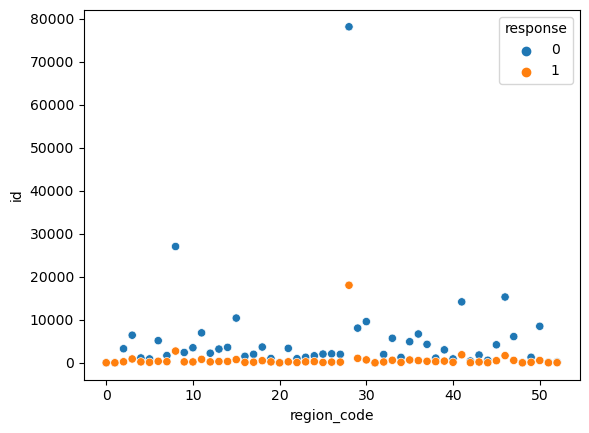

In [84]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

## 4.2. Bivariate Analysis

#### 1. Male customers have more damaged vehicles

In [85]:
H_1 = pd.crosstab(df4['gender'], df4['vehicle_damage'])
H_1['percentage %'] = round(H_1[1]/(H_1[1]+H_1[0])*100, 2)
H_1

vehicle_damage,0,1,percentage %
gender,,,
Female,82636,64079,43.68
Male,78797,89937,53.30


**True** 53% Male vs 44% Female



#### 2. Male customers are more interested in buy vehicle insurance

In [86]:
H_2 = pd.crosstab(df4['gender'], df4['response'])
H_2['percentage %'] = round(H_2[1]/(H_2[1]+H_2[0])*100, 2)
H_2

response,0,1,percentage %
gender,,,
Female,131981,14734,10.04
Male,145387,23347,13.84


**True** 14% Male vs 10% Female


#### 3. Customers that pay less annual premium are more interested in buy vehicle insurance

C:\Users\leona\AppData\Local\Temp\ipykernel_9556\3955845358.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


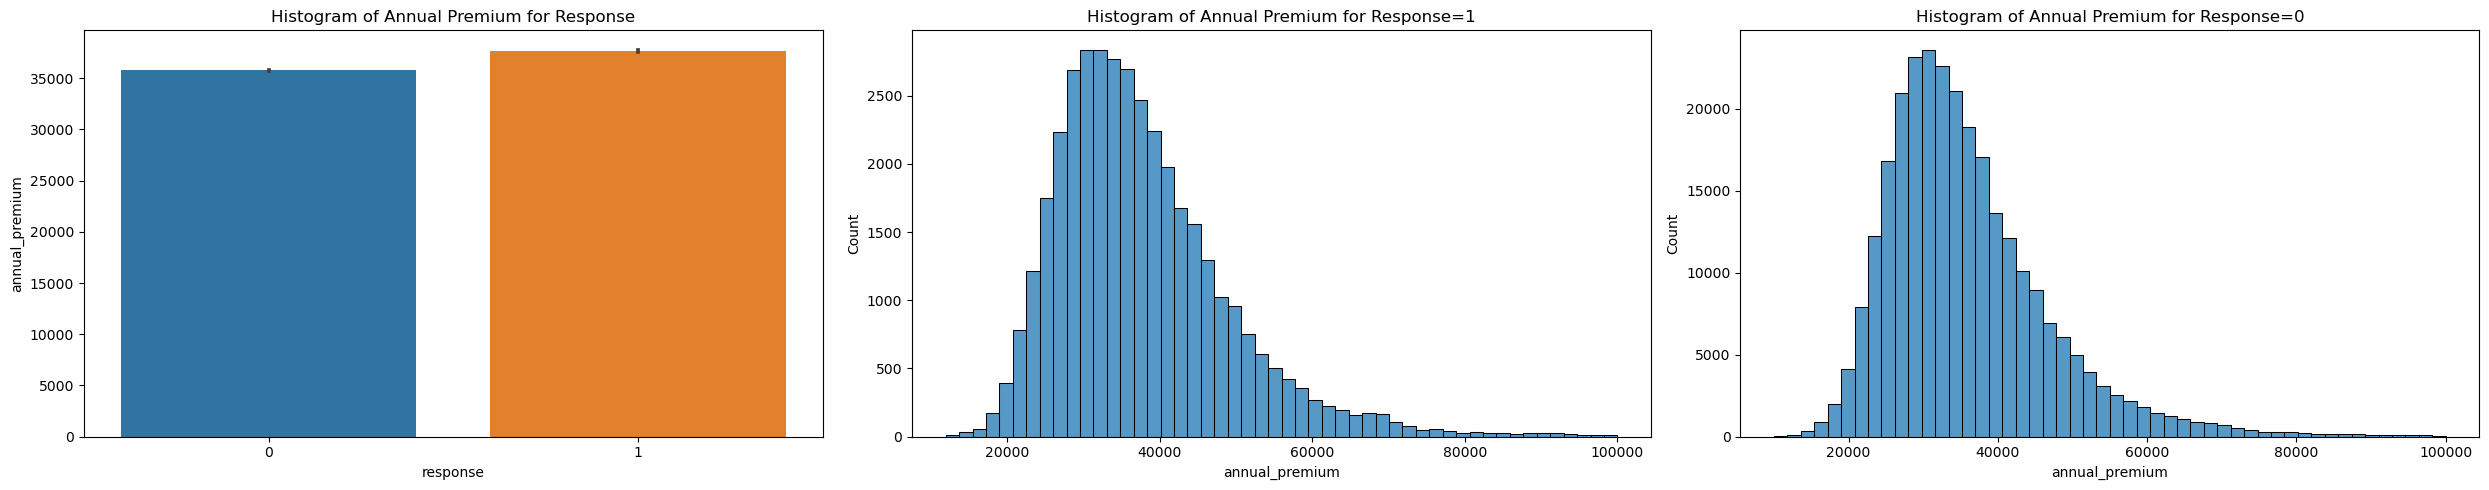

In [91]:
no_buy = df4[df4['response'] == 0]
buy =    df4[df4['response'] == 1]


fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='annual_premium', data=df4);
plt.title('Histogram of Annual Premium for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='annual_premium', bins=50, data=buy);
plt.title('Histogram of Annual Premium for Response=1')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='annual_premium', bins=50, data=no_buy);
plt.title('Histogram of Annual Premium for Response=0')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

**False** - There are no significant difference



#### 4. Long time period customers are more insterested in buy vehicle insurance


C:\Users\leona\AppData\Local\Temp\ipykernel_9556\4193548044.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


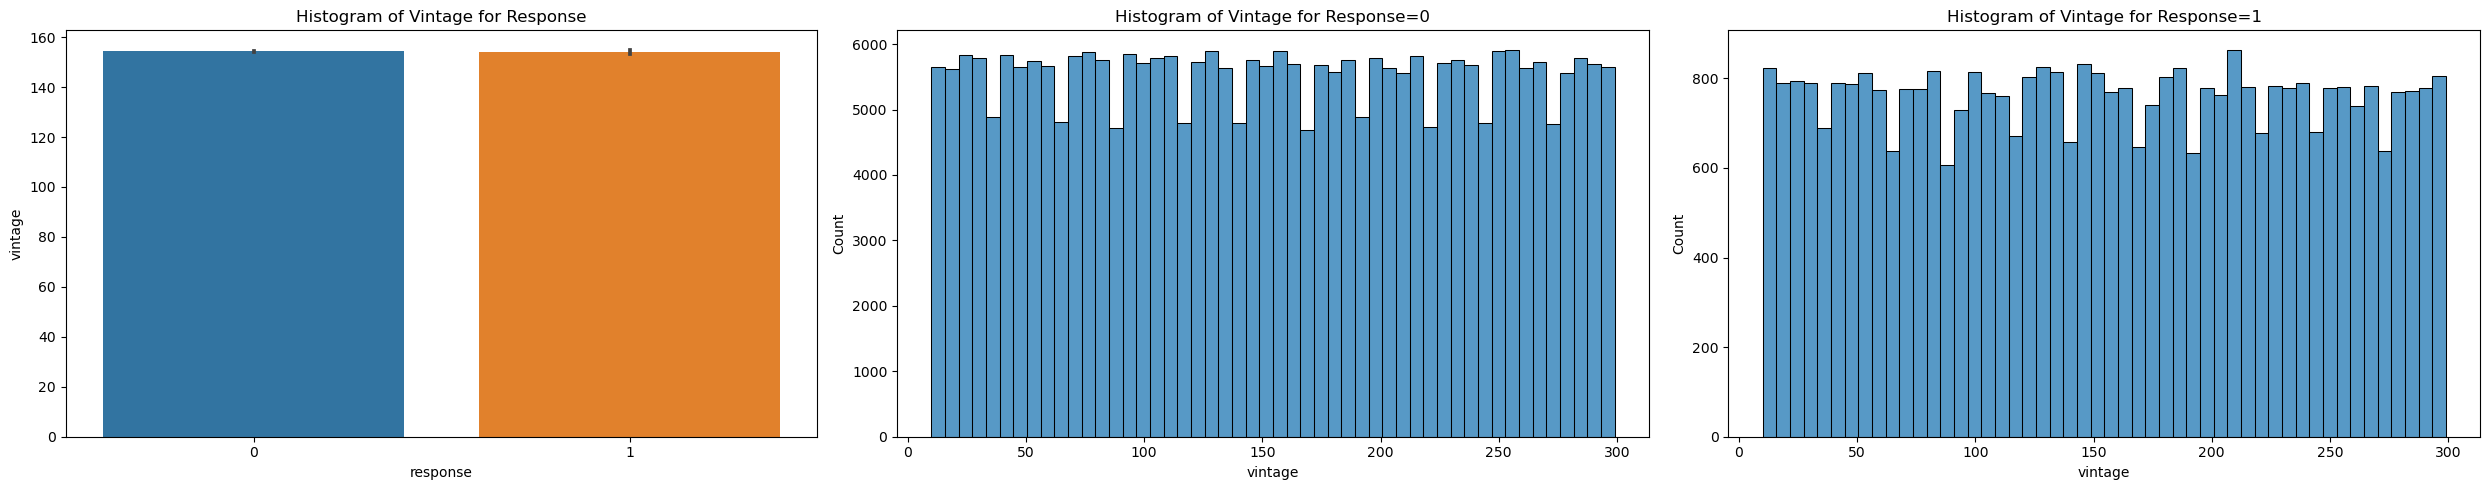

In [103]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='vintage', data=df4);
plt.title('Histogram of Vintage for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='vintage', bins=50, data=no_buy);
plt.title('Histogram of Vintage for Response=0')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='vintage', bins=50, data=buy);
plt.title('Histogram of Vintage for Response=1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

**False** - There are no significant difference

#### 5. Customers older than 40 are more interested in buy vehicle insurance


C:\Users\leona\AppData\Local\Temp\ipykernel_9556\1215352769.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


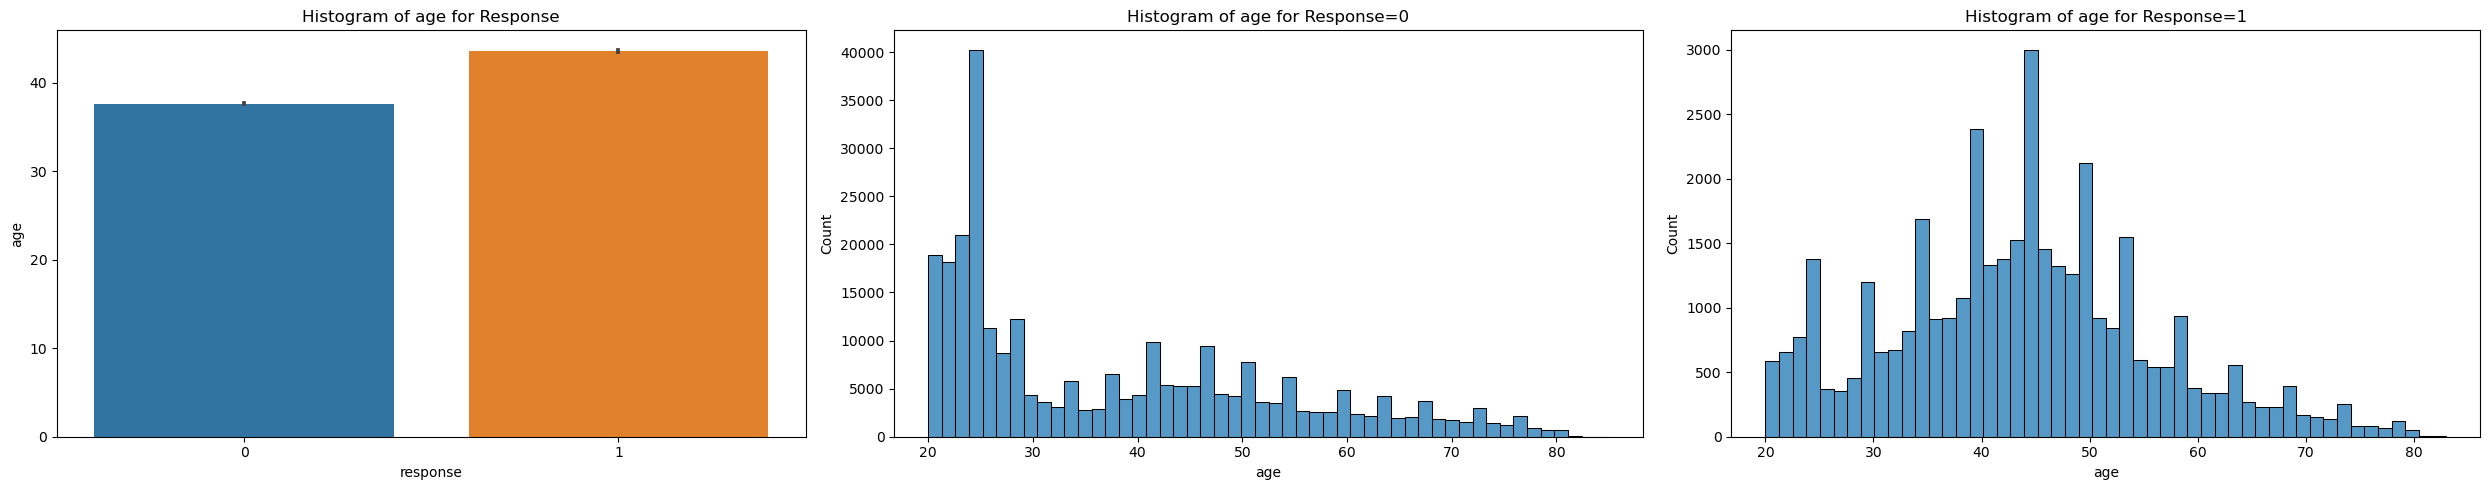

In [105]:
fig, ax = plt.subplots(figsize=(25, 5))

# Subplot 1
plt.subplot(1, 3, 1)
sns.barplot(x='response', y='age', data=df4);
plt.title('Histogram of age for Response')

# Subplot 2
plt.subplot(1, 3, 2)
sns.histplot(x='age', bins=50, data=no_buy);
plt.title('Histogram of age for Response=0')

# Subplot 3
plt.subplot(1, 3, 3)
sns.histplot(x='age', bins=50, data=buy);
plt.title('Histogram of age for Response=1')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [116]:
aux2 = df4.copy()
aux2['age_test'] = aux2['age'].apply(lambda x: 'over_40' if x>40 else 'under_40')

aux3 = pd.crosstab(aux2['age_test'], aux2['response'])
aux3['percentage %'] = round(aux3[1]/(aux3[1]+aux3[0])*100, 2)
aux3

response,0,1,percentage %
age_test,,,
over_40,109465,23179,17.47
under_40,167903,14902,8.15


**True** 17% over 40 vs 8% under 40 

#### 6. Customers with damaged vehicles are more interested in buy vehicle insurance

In [133]:
H_6 = pd.crosstab(df4['vehicle_damage'], df4['response'])
H_6['percentage %'] = round(H_6[1]/(H_6[1]+H_6[0])*100, 2)
H_6

response,0,1,percentage %
vehicle_damage,,,
0,160763,670,0.42
1,116605,37411,24.29


**True** 24% of customers with damaged vehicle are interested vs 0.4% of customers whitout damage

#### 7. Customers with newer vehicles are more interested in buy vehicle insurance

In [137]:
H_7 = pd.crosstab(df4['vehicle_age'], df4['response'])
H_7['percentage %'] = round(H_7[1]/(H_7[1]+H_7[0])*100, 2)
H_7

response,0,1,percentage %
vehicle_age,,,
below_1_year,137861,5994,4.17
between_1_2_year,130381,28017,17.69
over_2_years,9126,4070,30.84


**False** - 30% of customers with vechicles older than 2 years are interested vs 17% between 1 to 2 year vs 4% below 1 year. PS: number of customers with vehicles within 1 to 2 years old is much greater.


#### 8. Customers without driver license have less interest in buy vehicle insurance


In [144]:
H_8 = pd.crosstab(df4['driving_license'], df4['response'])
H_8['percentage %'] = round(H_8[1]/(H_8[1]+H_8[0])*100, 2)
H_8

response,0,1,percentage %
driving_license,,,
0,652,34,4.96
1,276716,38047,12.09


**True** - 5% of customers without license are interested vs 12% of customers with license.

#### 9. Customers region code have no influence in the interest they have in buying vehicle insurance

In [183]:
H_9_1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
H_9_2 = df4[['region_code', 'id']].groupby('region_code').count().reset_index()
H_9 = pd.merge(H_9_1, H_9_2, on='region_code', how='left')
H_9['percentage'] = H_9['response']/H_9['id']
H_9 = H_9.sort_values(by='percentage', ascending=False)
H_9.head()

,region_code,response,id,percentage
1,1.0,2,3,0.666667
0,0.0,9,21,0.428571
48,48.0,4,10,0.400000
20,20.0,3,8,0.375000
31,31.0,1,4,0.250000


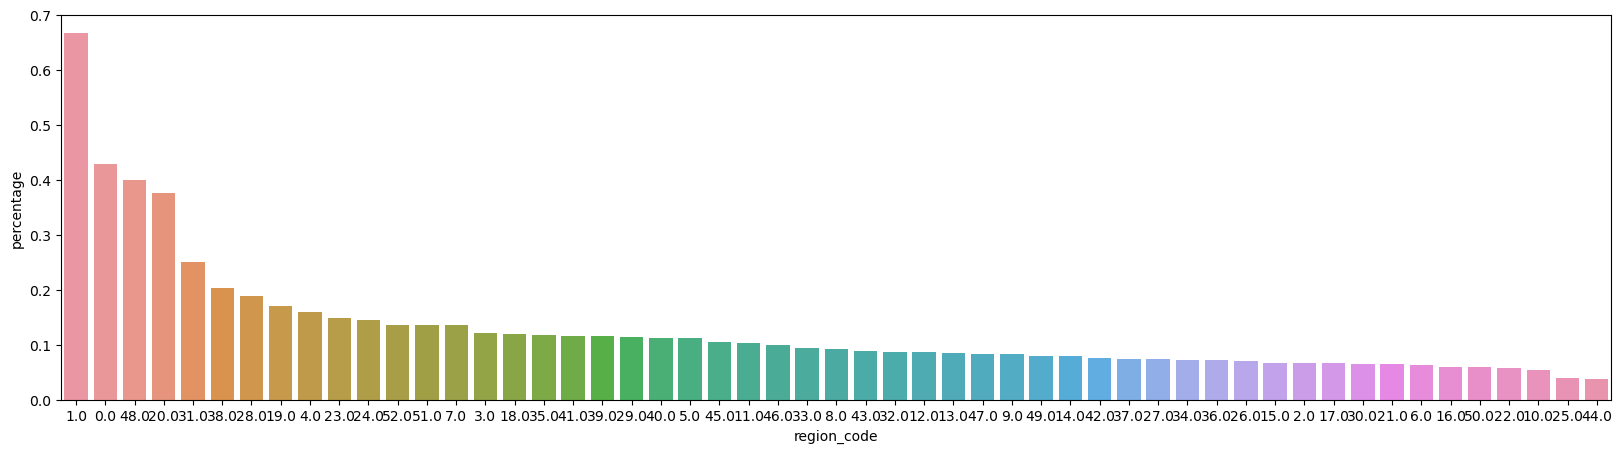

In [184]:
plt.subplots(figsize=(20, 5))
sns.barplot(x='region_code', y='percentage', data=H_9, order=H_9.region_code);

**False** - There is influence

#### 10. Customers policy_sales_channel have no influence in the interest they have in buying vehicle insurance

In [193]:
H_10_1 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
H_10_2 = df4[['policy_sales_channel', 'id']].groupby('policy_sales_channel').count().reset_index()
H_10 = pd.merge(H_10_1, H_10_2, on='policy_sales_channel', how='left')
H_10['percentage'] = H_10['response']/H_10['id']
H_10 = H_10.sort_values(by='percentage', ascending=False)
H_10.head()

,policy_sales_channel,response,id,percentage
114,123.0,1,1,1.000000
40,43.0,1,1,1.000000
94,101.0,2,5,0.400000
96,103.0,3,8,0.375000
7,9.0,4,11,0.363636


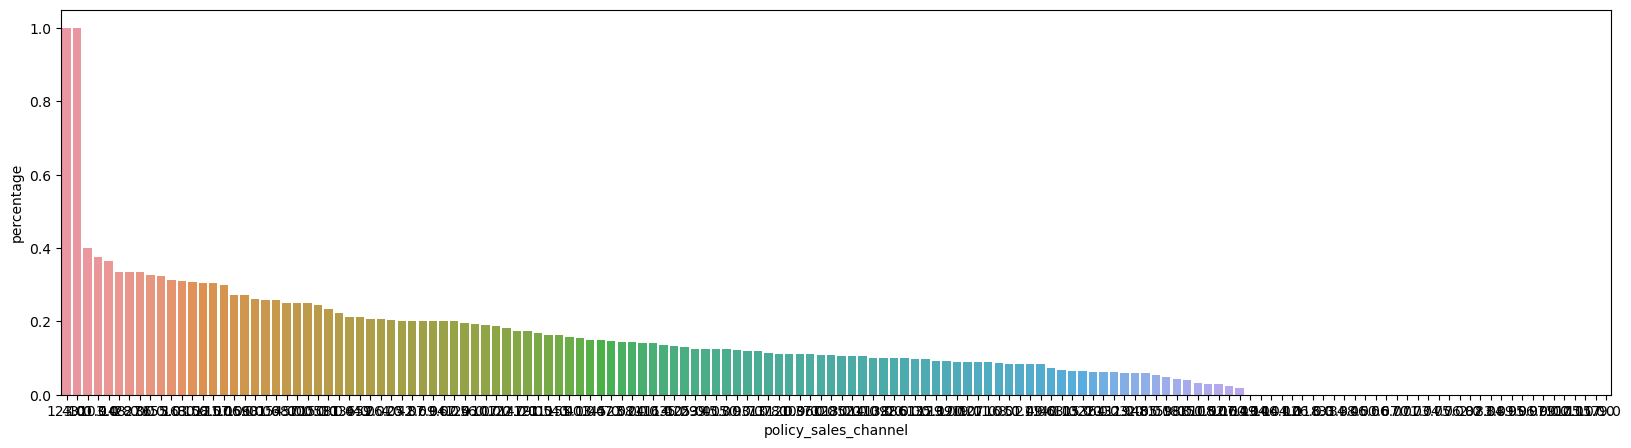

In [195]:
# H_10 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
# sns.barplot(x='response', y='policy_sales_channel', data=H_10);

plt.subplots(figsize=(20, 5))
sns.barplot(x='policy_sales_channel', y='percentage', data=H_10, order=H_10.policy_sales_channel);

**False** - There is influence



### 4.2.1. Summary of Hypotesis

In [197]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'Medium'],
       ['H2', 'True', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Medium'],
       ['H5', 'True', 'High'],
       ['H6', 'True', 'High'],
       ['H7', 'True', 'Medium'],
       ['H8', 'True', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'False', 'High']]
print(tabulate(tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           True          Medium
H2           True          Medium
H3           False         Medium
H4           False         Medium
H5           True          High
H6           True          High
H7           True          Medium
H8           True          High
H9           False         High
H10          False         High


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

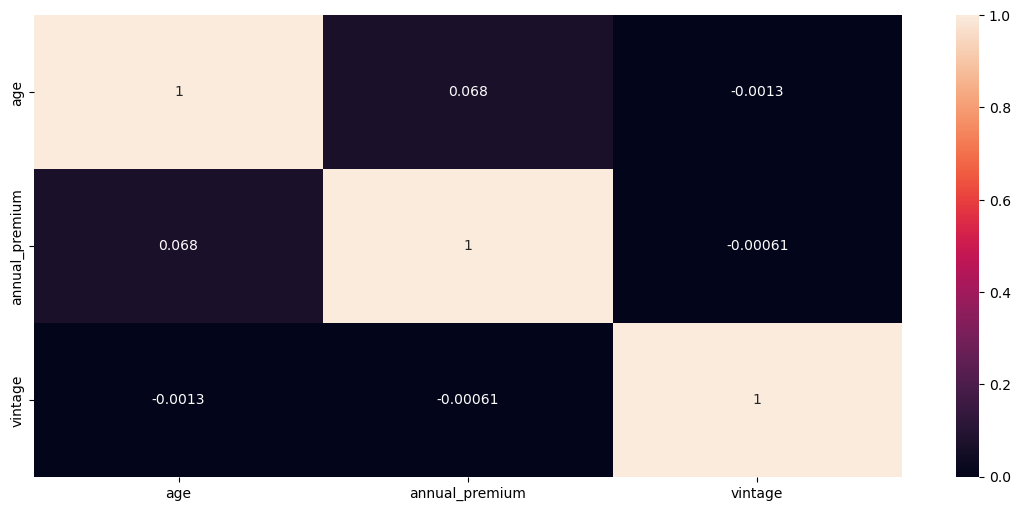

In [204]:
correlation = num_attributes.corr(method='pearson')

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

Para ver a correlação entre as variaveis categoricas vamos usar o [Cramér's V]('https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V')



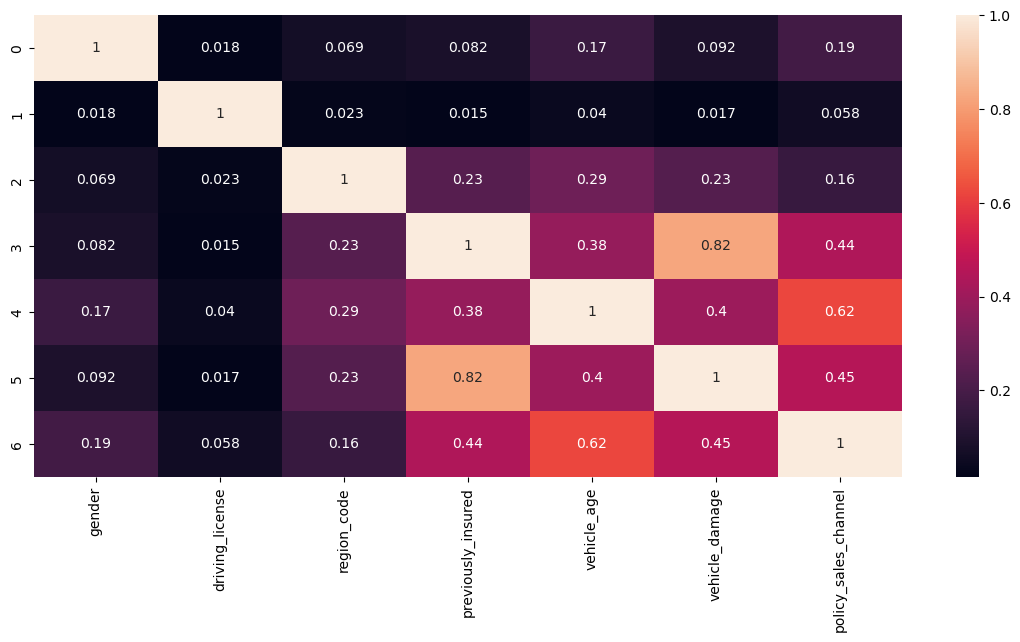

In [205]:
fig = plt.figure(figsize = (14, 6)) 
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);